# $\text{Jane Street Market Prediction}$

## $\text{Getting the data}$

In [1]:
# getting access to Google Drive to retrieve data
#from google.colab import drive
#drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
# changing the working directory
#%cd /content/gdrive/My Drive/Kaggle

/content/gdrive/My Drive/Kaggle


In [3]:
'''
!kaggle competitions download -c jane-street-market-prediction
!unzip \*.zip  && rm *.zip''';

In [1]:
# Data
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import plotly.express as px

In [7]:
%%time
train_data = pd.read_csv('C:/Users/Taha/Desktop/Spring 2021/JaneStreet/train.csv')

Wall time: 2min 7s


In [9]:
# difference columns between train and test set
#set(train_data.columns) - set(test_sample.columns)

## $\text{LightGMB}$

### $\text{Data Processing}$

In [10]:
train_data["action"] = train_data["resp"].apply(lambda x: int(x>0))

In [11]:
#cropped_train_data = train_data.loc[train_data.date > 85]

test_set = train_data[train_data.date > 399]
train_set = train_data[train_data.date <= 399]

train_set.date.nunique(), test_set.date.nunique()

(400, 100)

In [12]:
# percentage of trades in the test set
round(100*test_set.shape[0] / (train_data.shape[0]), 2)

21.42

In [13]:
def utility_score_last(date, weight, resp, action):
    count_i = date[-1] + 1 # Get number of days
    P_i = np.bincount(date, weight * resp * action) # Compute P_i
    t = np.sum(P_i) / np.sqrt(np.sum(P_i ** 2)) * np.sqrt(250 / count_i) # Compute t
    u = np.clip(t, 0, 6) * np.sum(P_i) # Combine to get utility score
    return u

In [14]:
predictors = list(set(train_data.columns) - {'resp', 'resp_1', 'resp_2', 'resp_3', 'resp_4', 'action', 'ts_id'})
outcome = ['action']

In [15]:
# Parameters for lightGBM. Objective is minimizing logloss
params = {'learning_rate': 0.01,
          'boosting': 'gbdt',
          'objective': 'binary',
          'num_leaves': 200,
          'min_data_in_leaf': 10,
          'max_bin': 200,
          'max_depth': 6,
          'seed': 2018,
          'nthread': 10}

In [22]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, confusion_matrix
import lightgbm as lgb

In [32]:
X_train, y_train = train_set[predictors], train_set[outcome]
ts = TimeSeriesSplit(n_splits=4)
for i in ts.split(X_train, y_train):
    print(len(i[0]), len(i[1]))

375673 375670
751343 375670
1127013 375670
1502683 375670


In [31]:
ts = TimeSeriesSplit(n_splits=4)
for fold_index, holdout_index in ts.split(X_train, y_train):     
    X_fold, X_holdout = X_train.iloc[fold_index,:].date.nunique(), X_train.iloc[holdout_index,:].date.nunique()
    print('Train: {}, Test: {}'.format(X_fold, X_holdout))

Train: 58, Test: 93
Train: 150, Test: 90
Train: 239, Test: 85
Train: 323, Test: 78


In [27]:
import gc

n_folds = 4
folds = TimeSeriesSplit(n_splits=n_folds)

splits = folds.split(train_set[predictors], train_set[outcome])

y_preds = np.zeros(test_set.shape[0])
y_oof = np.zeros(train_set.shape[0])
mean_score = []

feature_importances = pd.DataFrame()
feature_importances['feature'] = predictors

for fold_n, (train_index, valid_index) in enumerate(splits):

    print('Fold:', fold_n+1)
    
    X_train, X_valid = train_set[predictors].iloc[train_index], train_set[predictors].iloc[valid_index]
    y_train, y_valid = train_set[outcome].iloc[train_index], train_set[outcome].iloc[valid_index]

    d_train = lgb.Dataset(X_train, label=y_train)
    d_valid = lgb.Dataset(X_valid, label=y_valid)

    model = lgb.train(params, d_train, 2500, valid_sets = [d_train, d_valid], early_stopping_rounds = 50, verbose_eval=100)
    
    feature_importances[f'fold_{fold_n + 1}'] = model.feature_importance()

    y_pred_valid = np.round(model.predict(X_valid, num_iteration=model.best_iteration))

    y_oof[valid_index] = y_pred_valid
    
    val_score = accuracy_score(y_pred_valid, y_valid)

    print(f'val AUC score is {val_score}')

    mean_score.append(val_score)

    y_preds += model.predict(test_set[predictors], num_iteration=model.best_iteration) / n_folds

    del X_train, X_valid, y_train, y_valid
    gc.collect()

print('AUC score over folds is', np.mean(mean_score))

#test['demand'] = y_preds

Fold: 1
Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.674826	valid_1's binary_logloss: 0.692741
Early stopping, best iteration is:
[52]	training's binary_logloss: 0.681695	valid_1's binary_logloss: 0.69246
val AUC score is 0.5156706684057817
Fold: 2
Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.683086	valid_1's binary_logloss: 0.692676
Early stopping, best iteration is:
[86]	training's binary_logloss: 0.684093	valid_1's binary_logloss: 0.692655
val AUC score is 0.512039822184364
Fold: 3
Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.686456	valid_1's binary_logloss: 0.692672
Early stopping, best iteration is:
[120]	training's binary_logloss: 0.685583	valid_1's binary_logloss: 0.692653
val AUC score is 0.5105358426278382
Fold: 4
Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.688405	valid_1's b

### $\text{LightGBM: One Split}$

In [17]:
X_train, X_test, y_train, y_test = train_set[predictors],  test_set[predictors], train_set[outcome], test_set[outcome]

#print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

lgb_model = lgb.LGBMClassifier()
lgb_model.fit(X_train, y_train.values.reshape(len(y_train),), verbose=True)

LGBMClassifier()

In [18]:
y_pred = lgb_model.predict(X_test)

In [19]:
print("Accuracy of model is: ", accuracy_score(y_test, y_pred))

Accuracy of model is:  0.5136701435941095


In [20]:
print('Training set score: {:.4f}'.format(lgb_model.score(X_train, y_train)))
print('Test set score: {:.4f}'.format(lgb_model.score(X_test, y_test)))

Training set score: 0.5593
Test set score: 0.5137


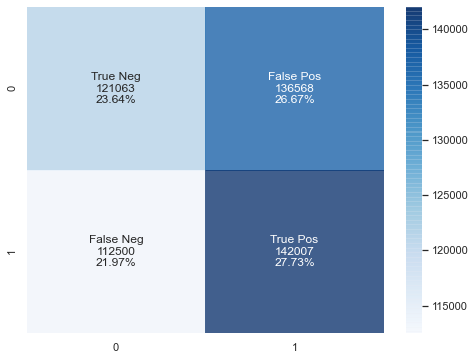

In [23]:
import seaborn as sns

def plot_cm(cm):
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_counts = ['{0:0.0f}'.format(value) for value in cm.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
              zip(group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.set(rc={'figure.figsize':(8, 6)})
    sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', alpha=.75)
    
plot_cm(confusion_matrix(y_test, y_pred));

### $\text{Hyperparameter Tunning: Bayesian Optimization}$

In [24]:
def lgbm_cv(max_depth, learning_rate, 
            n_estimators, reg_alpha,
            bagging_fraction, 
            min_child_weight, min_split_gain,
            colsample_bytree):
    
    estimator_function = lgb.LGBMClassifier(max_depth=int(max_depth),
                                            learning_rate = learning_rate,
                                            bagging_fraction = bagging_fraction,
                                            min_child_weight = min_child_weight,
                                            min_split_gain = min_split_gain,
                                            colsample_bytree = colsample_bytree,
                                            n_estimators = int(n_estimators),
                                            reg_alpha = reg_alpha, nthread = -1,
                                            objective = 'binary', seed = 42)
    
    estimator_function.fit(X_train, y_train.values.reshape(len(y_train),))
    probs = estimator_function.predict_proba(X_test)[:,1]
    return roc_auc_score(y_test, probs)

In [25]:
from bayes_opt import BayesianOptimization

gp_params = {"alpha": 1e-10}

hp_space = {
    'max_depth': (5, 30),
    'learning_rate': (.001, 1),
    'n_estimators' : (10, 250),
    'reg_alpha': (0, 1),
    'bagging_fraction': (.8, 1),
    'min_child_weight': (1, 25),
    'min_split_gain': (.001, .1),
    'colsample_bytree': (.1, 1)
}

lgbcBO = BayesianOptimization(f=lgbm_cv, pbounds=hp_space, random_state=42, verbose=10)

In [26]:
lgbcBO.maximize(init_points=5, n_iter=20, acq='ucb', kappa= 3, **gp_params)

|   iter    |  target   | baggin... | colsam... | learni... | max_depth | min_ch... | min_sp... | n_esti... | reg_alpha |
-------------------------------------------------------------------------------------------------------------------------
|  1        |  0.5186   |  0.8749   |  0.9556   |  0.7323   |  19.97    |  4.744    |  0.01644  |  23.94    |  0.8662   |
|  2        |  0.5161   |  0.9202   |  0.7373   |  0.02156  |  29.25    |  20.98    |  0.02202  |  53.64    |  0.1834   |
|  3        |  0.5193   |  0.8608   |  0.5723   |  0.4325   |  12.28    |  15.68    |  0.01481  |  80.11    |  0.3664   |
|  4        |  0.5178   |  0.8912   |  0.8067   |  0.2005   |  17.86    |  15.22    |  0.005599 |  155.8    |  0.1705   |
|  5        |  0.5097   |  0.813    |  0.954    |  0.9657   |  25.21    |  8.311    |  0.01067  |  174.2    |  0.4402   |
|  6        |  0.514    |  0.8511   |  0.4572   |  0.6415   |  12.33    |  14.34    |  0.09002  |  80.82    |  0.966    |
|  7        |  0.5159   